In [1]:
import keras
import tensorflow as tf
import json
import numpy as np 
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

# 临床数据fine-tune

In [2]:
test_dir = r'E:\1_code\图像分类\数据分析\武大\外部数据集测试\医院数据\train\dataset\testdataset'

height = 256#猴子图片的高度
width = 256#猴子图片的长度
channels = 3#彩色图片
batch_size = 10#每一次64个图片
num_classes = 5#最后是5分类
SEED=666

test_datagen = keras.preprocessing.image.ImageDataGenerator()#验证集不用添加图片，只需要将图片像素值进行规定
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    class_mode = "categorical")
test_num = test_generator.samples#获取训练样本总数
print("样本总数为：")
print(test_num)

Found 143 images belonging to 5 classes.
样本总数为：
143


In [3]:
from __future__ import absolute_import, print_function

import json
import math
import os
import sys

import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.callbacks import (LearningRateScheduler, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (Activation, Add, AveragePooling2D,
                                     BatchNormalization, Concatenate, Conv1D,
                                     Conv2D, Dense, Dropout, Flatten,
                                     GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Input, Lambda,
                                     LeakyReLU, Multiply, Permute, Reshape,
                                     multiply,ReLU)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras import layers
from keras import initializers
import math
from model1 import ConvNeXtBase, LayerScale
from model2 import SwinTransformerLarge384
class LayerScale(layers.Layer):
    """Layer scale module.

    References:
    - https://arxiv.org/abs/2103.17239

    Args:
    init_values (float): Initial value for layer scale. Should be within
        [0, 1].
    projection_dim (int): Projection dimensionality.

    Returns:
    Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            name="gamma",
            shape=(self.projection_dim,),
            initializer=initializers.Constant(self.init_values),
            trainable=True,
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def LightAttentionBlock(inputs,b=1, gamma=2,name=''):
    # 通道注意力机制
    channels = inputs.shape[-1]
    t = int(abs((math.log(channels, 2) + b) / gamma))
    k = t if t % 2 else t + 1
    x_global_avg_pool = GlobalAveragePooling2D(name=name+'GlobalAveragePooling2D')(inputs)
    x = Reshape((channels,1),name=name+'Reshape')(x_global_avg_pool)
    x = Conv1D(1, kernel_size=k,padding="same",name=name+'Conv1D')(x)
    x = Activation('sigmoid',name=name+'Activation')(x)
    x = Reshape((1, 1, channels),name=name+'Reshape2')(x)
    output = Multiply(name=name+'Multiply')([inputs,x])

    # 空间注意力机制
    x = tf.reduce_mean(output,axis=-1,keepdims=True,name=name+'reduce_mean')
    x = Activation('sigmoid',name=name+'Activation2')(x)
    output = Multiply(name=name+'Multiply2')([x, output])
    return output


def ConvNeXtBase_build_model(inputs_dim,num_classes,
                            input_shape=(512, 512, 3)):
    x_0,x_1,x_2,x_3,x = ConvNeXtBase(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)(inputs_dim)

    x = LightAttentionBlock(x,name='build_model_')
    x = GlobalAveragePooling2D(
        name='build_model_ConvNeXtBase_main_GlobalAveragePooling2D')(x)
    dp_1 = Dropout(0.5, name='build_model_ConvNeXtBase_main_Dropout1')(x)
    fc2_num_classes = Dense(
        512,
        kernel_initializer='he_normal',
        name='build_model_ConvNeXtBase_main_Dense_3')(dp_1)
    dp_2 = Dropout(0.5, name='build_model_ConvNeXtBase_main_Dropout2')(fc2_num_classes)
    fc2_num_classes2 = Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='build_model_ConvNeXtBase_main_Dense_4')(dp_2)
    fc2_num_classes2 = Activation(
        'softmax', name='build_model_ConvNeXtBase')(fc2_num_classes2)
    model = Model(inputs=inputs_dim, outputs=[x_0,x_1,x_2,x_3,fc2_num_classes2])
    # model.load_weights('/home/luyaping_w/project/code/EyeDR/DeepEnsembleLearning/SwinTransformerConvNeXt/0_数据预处理对比/Fusion/Test/model_1_weights.h5')
    
    model = Model(inputs=model.input, 
                outputs=[model.output[0],model.output[1],model.output[2],model.output[3],model.get_layer('build_model_ConvNeXtBase_main_GlobalAveragePooling2D').output])
    return model

def SwinTransformerLarge384_build_model(inputs_dim,num_classes,
                            input_shape=(512, 512, 3)):
    x_0,x_1,x_2,x_3,x = SwinTransformerLarge384(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)(inputs_dim)

    x = LightAttentionBlock(x,name='build_model_')
    x = GlobalAveragePooling2D(
        name='build_model_SwinTransformerLarge384_main_GlobalAveragePooling2D')(x)
    dp_1 = Dropout(0.5, name='build_model_SwinTransformerLarge384_main_Dropout1')(x)
    fc2_num_classes = Dense(
        512,
        kernel_initializer='he_normal',
        name='build_model_SwinTransformerLarge384_main_Dense_3')(dp_1)
    dp_2 = Dropout(0.5, name='build_model_SwinTransformerLarge384_main_Dropout2')(fc2_num_classes)
    fc2_num_classes2 = Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='build_model_SwinTransformerLarge384_main_Dense_4')(dp_2)
    fc2_num_classes2 = Activation(
        'softmax', name='build_model_SwinTransformerLarge384')(fc2_num_classes2)
    model = Model(inputs=inputs_dim, outputs=[x_0,x_1,x_2,x_3,fc2_num_classes2])
    # model.load_weights('/home/luyaping_w/project/code/EyeDR/DeepEnsembleLearning/SwinTransformerConvNeXt/0_数据预处理对比/Fusion/Test/model_2_weights.h5',by_name=True, skip_mismatch=True)
    
    model = Model(inputs=model.input, 
                outputs=[model.output[0],model.output[1],model.output[2],model.output[3],model.get_layer('build_model_SwinTransformerLarge384_main_GlobalAveragePooling2D').output])
    return model

def build_model(num_classes, input_shape):
    inputs_dim = Input(input_shape)
    ConvNeXtBase_0,ConvNeXtBase_1,ConvNeXtBase_2,ConvNeXtBase_3,ConvNeXtBase_num_classes = ConvNeXtBase_build_model(
        inputs_dim, num_classes, (input_shape[0], input_shape[1], input_shape[2]))(inputs_dim)
    SwinTransformerLarge384_0,SwinTransformerLarge384_1,SwinTransformerLarge384_2,SwinTransformerLarge384_3, SwinTransformerLarge384_0_num_classes = SwinTransformerLarge384_build_model(
        inputs_dim, num_classes, (input_shape[0], input_shape[1], input_shape[2]))(inputs_dim)

    # 第0层的拼接
    output_0 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(0)))([ConvNeXtBase_0,SwinTransformerLarge384_0])
    sq0 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(0))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(0))),
        ReLU(name='build_model_ReLU_{}'.format(str(0))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(0)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(0)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(0)),
    ],name='build_model_main_sq0')(output_0)
    sq0 = Activation('softmax',name='build_model_main_softmax_'+str(0))(sq0)
    # 第1层的拼接
    output_1 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(1)))([ConvNeXtBase_1,SwinTransformerLarge384_1])
    sq1 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(1))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(1))),
        ReLU(name='build_model_ReLU_{}'.format(str(1))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(1)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(1)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(1)),
    ],name='build_model_main_sq1')(output_1)
    sq1 = Activation('softmax',name='build_model_main_softmax_'+str(1))(sq1)
    # 第2层的拼接
    output_2 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(2)))([ConvNeXtBase_2,SwinTransformerLarge384_2])
    sq2 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(2))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(2))),
        ReLU(name='build_model_ReLU_{}'.format(str(2))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(2)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(2)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(2))
    ],name='build_model_main_sq2')(output_2)
    sq2 = Activation('softmax',name='build_model_main_softmax_'+str(2))(sq2)
    
    # 第3层的拼接
    output_3 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(3)))([ConvNeXtBase_3,SwinTransformerLarge384_3])
    sq3 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(3))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(3))),
        ReLU(name='build_model_ReLU_{}'.format(str(3))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(3)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(3)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(3)),
    ],name='build_model_main_sq')(output_3)
    sq3 = Activation('softmax',name='build_model_main_softmax_{}'.format(str(3)))(sq3)
    # label的拼接
    model = Concatenate(name='build_model_main_Concatenate')([
        ConvNeXtBase_num_classes, SwinTransformerLarge384_0_num_classes
    ])
    model = Dropout(0.6, name='build_model_main_Dropout_1')(model)
    model = Dense(512,
                    kernel_initializer='he_normal',
                    name='build_model_main_Dense_1')(model)
    model = LeakyReLU(alpha=0.0001,
                    name='build_model_main_LeakyReLU')(
                        model)  #此处注意，为sigmoid函数
    model = Dropout(0.6, name='build_model_main_Dropout_2')(model)
    model = Dense(num_classes,
                    kernel_initializer='he_normal',
                    name='build_model_main_Dense_2')(model)
    All_num_classes = Activation('softmax',
                                    name='build_model_All_num_classes')(
                                        model)  #此处注意，为sigmoid函数
    model = Model(inputs=inputs_dim,
                    outputs=[sq0,sq1,sq2,sq3,All_num_classes])
    return model

height = 256
width = 256
channels = 3
batch_size = 8*4
num_classes = 5
SEED = 666
epochs = 300
input_shape = (height, width, channels)
model = build_model(num_classes,input_shape)
model.load_weights(r'E:\1_code\图像分类\数据分析\武大\外部数据集测试\医院数据\train\dataset\外部数据集测试\Fusion/callbacks_EarlyStopping_04_0.8531.h5')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 64, 64, 128  87566470    ['input_1[0][0]']                
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                                
                                 (None, 16, 16, 512                                         

In [4]:
test_predict = model.predict_generator(test_generator)#是使用进程还是线

test_predict_class_indices = np.argmax(test_predict[-1], axis = 1)#找到预测类别是哪一个   哪个值最大就是哪一类

y_test=test_generator.classes

from sklearn.metrics import classification_report
target_names = ['0', '1', '2','3','4']
print(classification_report(y_test, test_predict_class_indices, target_names=target_names,digits=4))

C:\Users\user\AppData\Local\Temp\ipykernel_28064\2904143784.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predict = model.predict_generator(test_generator)#是使用进程还是线


              precision    recall  f1-score   support

           0     0.8400    0.7778    0.8077        27
           1     0.8333    0.7692    0.8000        13
           2     0.8125    0.8864    0.8478        44
           3     0.8182    0.7826    0.8000        23
           4     0.9444    0.9444    0.9444        36

    accuracy                         0.8531       143
   macro avg     0.8497    0.8321    0.8400       143
weighted avg     0.8537    0.8531    0.8525       143



In [5]:
# 准确度Accuracy
from sklearn.metrics import accuracy_score
print('准确度Accuracy为: ', accuracy_score(y_test, test_predict_class_indices))

准确度Accuracy为:  0.8531468531468531


In [6]:
# F1值为:
from sklearn.metrics import f1_score
print('f1_score为weighted: ', f1_score(y_test, test_predict_class_indices,average='weighted'))
print('f1_score为macro: ', f1_score(y_test, test_predict_class_indices,average='macro'))

f1_score为weighted:  0.8525317491872676
f1_score为macro:  0.8399925678186548


In [7]:
# AUC值为:
from sklearn.metrics import roc_auc_score
print('roc_auc_score为weighted: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovr',average='weighted'))
print('roc_auc_score为macro: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovo',average='macro'))

roc_auc_score为weighted:  0.9579221387204977
roc_auc_score为macro:  0.950502536357005


In [8]:
test_generator.filenames

['0\\18451_20200903_093755_Color_L_006.JPG',
 '0\\18451_20200903_093755_Color_R_003.JPG',
 '0\\18451_20200903_093755_Color_R_005.JPG',
 '0\\18453_20200903_140846_Color_R_001.JPG',
 '0\\18454_20200904_144030_Color_L_007.JPG',
 '0\\18454_20200904_144030_Color_L_009.JPG',
 '0\\18454_20200904_144030_Color_L_010.JPG',
 '0\\18454_20200904_144030_Color_R_006.JPG',
 '0\\18463_20200909_141442_Color_L_001.JPG',
 '0\\18463_20200909_141442_Color_L_009.JPG',
 '0\\18463_20200909_141442_Color_R_001.JPG',
 '0\\18496_20200930_144912_Color_L_006.JPG',
 '0\\18496_20200930_144912_Color_R_007.JPG',
 '0\\18628_20201225_095929_Color_L_002.JPG',
 '0\\18628_20201225_095929_Color_L_003.JPG',
 '0\\18643_20210107_144528_Color_R_002.JPG',
 '0\\18644_20210111_094052_Color_R_001.JPG',
 '0\\18644_20210111_094052_Color_R_002.JPG',
 '0\\18658_20210118_102824_Color_R_002.JPG',
 '0\\18667_20210125_092815_Color_L_001.JPG',
 '0\\18674_20210126_102433_Color_R_001.JPG',
 '0\\18676_20210127_092653_Color_R_001.JPG',
 '0\\18901

In [9]:
test_predict_class_indices

array([0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_predict_class_indices)

array([[21,  2,  2,  2,  0],
       [ 1, 10,  2,  0,  0],
       [ 3,  0, 39,  1,  1],
       [ 0,  0,  4, 18,  1],
       [ 0,  0,  1,  1, 34]], dtype=int64)

In [11]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices)

0.8087748344370861

In [12]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices,weights='quadratic')

0.8952063275465595

In [13]:
test_predict_class_indices

array([0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [14]:
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

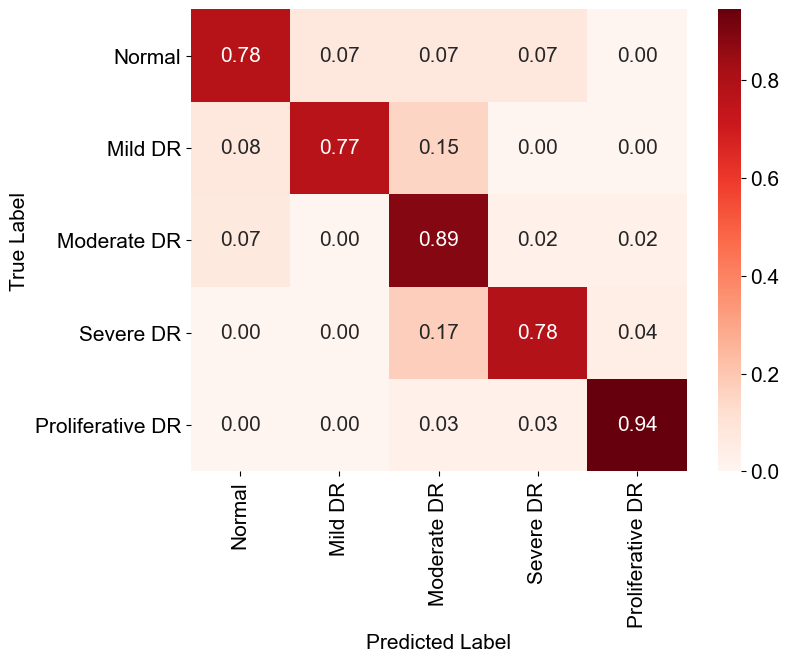

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# 设置全局字体样式为Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
# 生成混淆矩阵数据（这里使用随机数据作为示例）
confusion_matrix = confusion_matrix(y_test, test_predict_class_indices)
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)  # 将每一行归一化为概率

# 设置画布大小
plt.figure(figsize=(8, 6))

# 绘制热力图
sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap='Reds', cbar=True)

# 更改 x 轴和 y 轴的标签
plt.xticks(ticks=np.arange(5)+0.5, labels=['Normal', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'],rotation=90)
plt.yticks(ticks=np.arange(5)+0.5, labels=['Normal', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'],rotation=0)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.title('Confusion Matrix')
plt.savefig('外部数据集混淆矩阵.svg',format='svg')
plt.show()

# 临床数据直接测试

In [16]:
test_dir = r'E:\1_code\图像分类\数据分析\武大\外部数据集测试\医院数据\train\dataset\testdataset'

height = 256#猴子图片的高度
width = 256#猴子图片的长度
channels = 3#彩色图片
batch_size = 10#每一次64个图片
num_classes = 5#最后是5分类
SEED=666

test_datagen = keras.preprocessing.image.ImageDataGenerator()#验证集不用添加图片，只需要将图片像素值进行规定
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    class_mode = "categorical")
test_num = test_generator.samples#获取训练样本总数
print("样本总数为：")
print(test_num)

Found 143 images belonging to 5 classes.
样本总数为：
143


In [17]:
from __future__ import absolute_import, print_function

import json
import math
import os
import sys

import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.callbacks import (LearningRateScheduler, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (Activation, Add, AveragePooling2D,
                                     BatchNormalization, Concatenate, Conv1D,
                                     Conv2D, Dense, Dropout, Flatten,
                                     GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Input, Lambda,
                                     LeakyReLU, Multiply, Permute, Reshape,
                                     multiply,ReLU)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras import layers
from keras import initializers
import math
from model1 import ConvNeXtBase, LayerScale
from model2 import SwinTransformerLarge384
class LayerScale(layers.Layer):
    """Layer scale module.

    References:
    - https://arxiv.org/abs/2103.17239

    Args:
    init_values (float): Initial value for layer scale. Should be within
        [0, 1].
    projection_dim (int): Projection dimensionality.

    Returns:
    Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            name="gamma",
            shape=(self.projection_dim,),
            initializer=initializers.Constant(self.init_values),
            trainable=True,
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def LightAttentionBlock(inputs,b=1, gamma=2,name=''):
    # 通道注意力机制
    channels = inputs.shape[-1]
    t = int(abs((math.log(channels, 2) + b) / gamma))
    k = t if t % 2 else t + 1
    x_global_avg_pool = GlobalAveragePooling2D(name=name+'GlobalAveragePooling2D')(inputs)
    x = Reshape((channels,1),name=name+'Reshape')(x_global_avg_pool)
    x = Conv1D(1, kernel_size=k,padding="same",name=name+'Conv1D')(x)
    x = Activation('sigmoid',name=name+'Activation')(x)
    x = Reshape((1, 1, channels),name=name+'Reshape2')(x)
    output = Multiply(name=name+'Multiply')([inputs,x])

    # 空间注意力机制
    x = tf.reduce_mean(output,axis=-1,keepdims=True,name=name+'reduce_mean')
    x = Activation('sigmoid',name=name+'Activation2')(x)
    output = Multiply(name=name+'Multiply2')([x, output])
    return output


def ConvNeXtBase_build_model(inputs_dim,num_classes,
                            input_shape=(512, 512, 3)):
    x_0,x_1,x_2,x_3,x = ConvNeXtBase(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)(inputs_dim)

    x = LightAttentionBlock(x,name='build_model_')
    x = GlobalAveragePooling2D(
        name='build_model_ConvNeXtBase_main_GlobalAveragePooling2D')(x)
    dp_1 = Dropout(0.5, name='build_model_ConvNeXtBase_main_Dropout1')(x)
    fc2_num_classes = Dense(
        512,
        kernel_initializer='he_normal',
        name='build_model_ConvNeXtBase_main_Dense_3')(dp_1)
    dp_2 = Dropout(0.5, name='build_model_ConvNeXtBase_main_Dropout2')(fc2_num_classes)
    fc2_num_classes2 = Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='build_model_ConvNeXtBase_main_Dense_4')(dp_2)
    fc2_num_classes2 = Activation(
        'softmax', name='build_model_ConvNeXtBase')(fc2_num_classes2)
    model = Model(inputs=inputs_dim, outputs=[x_0,x_1,x_2,x_3,fc2_num_classes2])
    # model.load_weights('/home/luyaping_w/project/code/EyeDR/DeepEnsembleLearning/SwinTransformerConvNeXt/0_数据预处理对比/Fusion/Test/model_1_weights.h5')
    
    model = Model(inputs=model.input, 
                outputs=[model.output[0],model.output[1],model.output[2],model.output[3],model.get_layer('build_model_ConvNeXtBase_main_GlobalAveragePooling2D').output])
    return model

def SwinTransformerLarge384_build_model(inputs_dim,num_classes,
                            input_shape=(512, 512, 3)):
    x_0,x_1,x_2,x_3,x = SwinTransformerLarge384(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)(inputs_dim)

    x = LightAttentionBlock(x,name='build_model_')
    x = GlobalAveragePooling2D(
        name='build_model_SwinTransformerLarge384_main_GlobalAveragePooling2D')(x)
    dp_1 = Dropout(0.5, name='build_model_SwinTransformerLarge384_main_Dropout1')(x)
    fc2_num_classes = Dense(
        512,
        kernel_initializer='he_normal',
        name='build_model_SwinTransformerLarge384_main_Dense_3')(dp_1)
    dp_2 = Dropout(0.5, name='build_model_SwinTransformerLarge384_main_Dropout2')(fc2_num_classes)
    fc2_num_classes2 = Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='build_model_SwinTransformerLarge384_main_Dense_4')(dp_2)
    fc2_num_classes2 = Activation(
        'softmax', name='build_model_SwinTransformerLarge384')(fc2_num_classes2)
    model = Model(inputs=inputs_dim, outputs=[x_0,x_1,x_2,x_3,fc2_num_classes2])
    # model.load_weights('/home/luyaping_w/project/code/EyeDR/DeepEnsembleLearning/SwinTransformerConvNeXt/0_数据预处理对比/Fusion/Test/model_2_weights.h5',by_name=True, skip_mismatch=True)
    
    model = Model(inputs=model.input, 
                outputs=[model.output[0],model.output[1],model.output[2],model.output[3],model.get_layer('build_model_SwinTransformerLarge384_main_GlobalAveragePooling2D').output])
    return model

def build_model(num_classes, input_shape):
    inputs_dim = Input(input_shape)
    ConvNeXtBase_0,ConvNeXtBase_1,ConvNeXtBase_2,ConvNeXtBase_3,ConvNeXtBase_num_classes = ConvNeXtBase_build_model(
        inputs_dim, num_classes, (input_shape[0], input_shape[1], input_shape[2]))(inputs_dim)
    SwinTransformerLarge384_0,SwinTransformerLarge384_1,SwinTransformerLarge384_2,SwinTransformerLarge384_3, SwinTransformerLarge384_0_num_classes = SwinTransformerLarge384_build_model(
        inputs_dim, num_classes, (input_shape[0], input_shape[1], input_shape[2]))(inputs_dim)

    # 第0层的拼接
    output_0 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(0)))([ConvNeXtBase_0,SwinTransformerLarge384_0])
    sq0 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(0))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(0))),
        ReLU(name='build_model_ReLU_{}'.format(str(0))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(0)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(0)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(0)),
    ],name='build_model_main_sq0')(output_0)
    sq0 = Activation('softmax',name='build_model_main_softmax_'+str(0))(sq0)
    # 第1层的拼接
    output_1 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(1)))([ConvNeXtBase_1,SwinTransformerLarge384_1])
    sq1 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(1))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(1))),
        ReLU(name='build_model_ReLU_{}'.format(str(1))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(1)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(1)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(1)),
    ],name='build_model_main_sq1')(output_1)
    sq1 = Activation('softmax',name='build_model_main_softmax_'+str(1))(sq1)
    # 第2层的拼接
    output_2 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(2)))([ConvNeXtBase_2,SwinTransformerLarge384_2])
    sq2 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(2))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(2))),
        ReLU(name='build_model_ReLU_{}'.format(str(2))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(2)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(2)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(2))
    ],name='build_model_main_sq2')(output_2)
    sq2 = Activation('softmax',name='build_model_main_softmax_'+str(2))(sq2)
    
    # 第3层的拼接
    output_3 = Concatenate(axis=-1,name='build_model_Concatenate_{}'.format(str(3)))([ConvNeXtBase_3,SwinTransformerLarge384_3])
    sq3 = tf.keras.Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_initializer='he_normal',
                        name='build_model_conv2D_{}'.format(str(3))),
        BatchNormalization(name='build_model_BatchNormalization_{}'.format(str(3))),
        ReLU(name='build_model_ReLU_{}'.format(str(3))),
        GlobalAveragePooling2D(name='build_model_main_GlobalAveragePooling2D_'+str(3)),
        Dropout(0.6, name='build_model_main_Dropout_'+str(3)),
        Dense(num_classes,kernel_initializer='he_normal',name='build_model_main_Dense_1_'+str(3)),
    ],name='build_model_main_sq')(output_3)
    sq3 = Activation('softmax',name='build_model_main_softmax_{}'.format(str(3)))(sq3)
    # label的拼接
    model = Concatenate(name='build_model_main_Concatenate')([
        ConvNeXtBase_num_classes, SwinTransformerLarge384_0_num_classes
    ])
    model = Dropout(0.6, name='build_model_main_Dropout_1')(model)
    model = Dense(512,
                    kernel_initializer='he_normal',
                    name='build_model_main_Dense_1')(model)
    model = LeakyReLU(alpha=0.0001,
                    name='build_model_main_LeakyReLU')(
                        model)  #此处注意，为sigmoid函数
    model = Dropout(0.6, name='build_model_main_Dropout_2')(model)
    model = Dense(num_classes,
                    kernel_initializer='he_normal',
                    name='build_model_main_Dense_2')(model)
    All_num_classes = Activation('softmax',
                                    name='build_model_All_num_classes')(
                                        model)  #此处注意，为sigmoid函数
    model = Model(inputs=inputs_dim,
                    outputs=[sq0,sq1,sq2,sq3,All_num_classes])
    return model

height = 256
width = 256
channels = 3
batch_size = 8*4
num_classes = 5
SEED = 666
epochs = 300
input_shape = (height, width, channels)
model = build_model(num_classes,input_shape)
model.load_weights(r'E:\1_code\图像分类\数据分析\武大\最终模型\2_Fusion\最完整的模型/callbacks_EarlyStopping_13_0.8179.h5')
model.summary()

KeyboardInterrupt: 

In [ ]:
test_predict = model.predict_generator(test_generator)#是使用进程还是线

test_predict_class_indices = np.argmax(test_predict[-1], axis = 1)#找到预测类别是哪一个   哪个值最大就是哪一类

y_test=test_generator.classes

from sklearn.metrics import classification_report
target_names = ['0', '1', '2','3','4']
print(classification_report(y_test, test_predict_class_indices, target_names=target_names,digits=4))

<ipython-input-15-527621f57f5d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predict = model.predict_generator(test_generator)#是使用进程还是线


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        27
           1     0.0769    0.0769    0.0769        13
           2     0.3636    0.7273    0.4848        44
           3     0.3214    0.3913    0.3529        23
           4     0.7857    0.3056    0.4400        36

    accuracy                         0.3706       143
   macro avg     0.3095    0.3002    0.2709       143
weighted avg     0.3684    0.3706    0.3237       143



d:\1_software\2_Application_software\2_Office\3_Anaconda3\software\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\1_software\2_Application_software\2_Office\3_Anaconda3\software\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\1_software\2_Application_software\2_Office\3_Anaconda3\software\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [ ]:
# 准确度Accuracy
from sklearn.metrics import accuracy_score
print('准确度Accuracy为: ', accuracy_score(y_test, test_predict_class_indices))

准确度Accuracy为:  0.3706293706293706


In [ ]:
# F1值为:
from sklearn.metrics import f1_score
print('f1_score为weighted: ', f1_score(y_test, test_predict_class_indices,average='weighted'))
print('f1_score为macro: ', f1_score(y_test, test_predict_class_indices,average='macro'))

f1_score为weighted:  0.3237131495955025
f1_score为macro:  0.27094254764843


In [ ]:
# AUC值为:
from sklearn.metrics import roc_auc_score
print('roc_auc_score为weighted: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovr',average='weighted'))
print('roc_auc_score为macro: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovo',average='macro'))

roc_auc_score为weighted:  0.6372104901240646
roc_auc_score为macro:  0.6306936616568258


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_predict_class_indices)

array([[ 0, 10, 17,  0,  0],
       [ 0,  1, 12,  0,  0],
       [ 0,  2, 32,  8,  2],
       [ 0,  0, 13,  9,  1],
       [ 0,  0, 14, 11, 11]], dtype=int64)

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices)

0.1566186107470512

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices,weights='quadratic')

0.4866374152373354

# kaggle测试

In [ ]:
test_dir = r'E:\1_code\图像分类\3_DRTestDatasetsProcess'

height = 256#猴子图片的高度
width = 256#猴子图片的长度
channels = 3#彩色图片
batch_size = 10#每一次64个图片
num_classes = 5#最后是5分类
SEED=666

test_datagen = keras.preprocessing.image.ImageDataGenerator()#验证集不用添加图片，只需要将图片像素值进行规定
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    class_mode = "categorical")
test_num = test_generator.samples#获取训练样本总数
print("样本总数为：")
print(test_num)

Found 7030 images belonging to 5 classes.
样本总数为：
7030


In [ ]:
test_predict = model.predict_generator(test_generator)#是使用进程还是线

test_predict_class_indices = np.argmax(test_predict[-1], axis = 1)#找到预测类别是哪一个   哪个值最大就是哪一类

y_test=test_generator.classes

from sklearn.metrics import classification_report
target_names = ['0', '1', '2','3','4']
print(classification_report(y_test, test_predict_class_indices, target_names=target_names,digits=4))

<ipython-input-23-527621f57f5d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predict = model.predict_generator(test_generator)#是使用进程还是线


              precision    recall  f1-score   support

           0     0.8446    0.9768    0.9059      5162
           1     0.5455    0.0122    0.0240       490
           2     0.6570    0.5590    0.6041      1059
           3     0.6667    0.2614    0.3755       176
           4     0.8354    0.4615    0.5946       143

    accuracy                         0.8182      7030
   macro avg     0.7098    0.4542    0.5008      7030
weighted avg     0.7908    0.8182    0.7793      7030



In [ ]:
# 准确度Accuracy
from sklearn.metrics import accuracy_score
print('准确度Accuracy为: ', accuracy_score(y_test, test_predict_class_indices))

准确度Accuracy为:  0.8182076813655761


In [ ]:
# F1值为:
from sklearn.metrics import f1_score
print('f1_score为weighted: ', f1_score(y_test, test_predict_class_indices,average='weighted'))
print('f1_score为macro: ', f1_score(y_test, test_predict_class_indices,average='macro'))

f1_score为weighted:  0.7793185740215183
f1_score为macro:  0.5007991031997227


In [ ]:
# AUC值为:
from sklearn.metrics import roc_auc_score
print('roc_auc_score为weighted: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovr',average='weighted'))
print('roc_auc_score为macro: ', roc_auc_score(y_test, test_predict[-1],multi_class='ovo',average='macro'))

roc_auc_score为weighted:  0.8143063272515884
roc_auc_score为macro:  0.7193323361451769


In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices)

0.4901278434483851

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, test_predict_class_indices,weights='quadratic')

0.6912427784579609